In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, log_loss
import keras
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.utils import np_utils
from keras.layers.core import Dropout

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Content
- Preliminary EDA
- EDA of selected features & correlation

Preprocessing
- Drop selected features
- Encoding
- Scaling

Prepare test and training dataset

Models
- Descision Tree [X]
- Logistic regression [X]
- XGBoost (eXtreme Gradient Boosting) [X]
- Multilayer Perceptron with Focal Loss [X]

For all models
- Hyperparameter tuninig
- Stratified Cross validation & test 

# Import data

In [2]:
#specify date format before import
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [3]:
#read in data (without specifying data type)
df = pd.read_csv('ClickThrough_ReducedTrainingSet.csv', parse_dates = ['hour'],
                        date_parser = parse_date)

In [5]:
#specify data types before reading in data to save space
data_types = {
    'id': np.uint16,
    'hour': np.str,
    'click': np.uint16,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16
}

#load data and specify that the hour column should be in datetime-format
df = pd.read_csv('ClickThrough_ReducedTrainingSet.csv', parse_dates = ['hour'],
                        date_parser = parse_date, 
                        dtype = data_types)

In [6]:
#extract time-related features into separate columns
df['hour_day'] = df.hour.apply(lambda x: x.hour).astype(np.uint16)
df['day_of_week'] = df.hour.apply(lambda val: val.dayofweek).astype(np.uint16)

In [7]:
df.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_day,day_of_week
0,14641,0,2014-10-23 04:00:00,1005,1,e4d8dd7b,a17bde68,3e814130,ecad2386,7801e8d9,...,16208,320,50,1800,3,167,34541,23,4,3
1,35866,1,2014-10-23 04:00:00,1005,0,5bcf81a2,9d54950b,f028772b,ecad2386,7801e8d9,...,22116,320,50,2547,2,35,65535,13,4,3
2,10513,0,2014-10-23 04:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,22102,320,50,2545,0,35,34548,221,4,3


# Preliminary EDA

In [6]:
#look at column titles / features
df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_day',
       'day_of_week'],
      dtype='object')

In [7]:
#check number of rows and columns 
df.shape

(400000, 26)

In [8]:
#get stats on numerical fields
df.describe()

,id,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_day,day_of_week
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,32763.779608,0.169805,1004.966760,0.288005,1.014957,0.329332,18842.328405,318.908190,60.108290,2112.355170,1.433195,227.530780,49081.511717,83.385338,11.283368,2.596005
std,18924.819596,0.375462,1.100556,0.506279,0.529622,0.853410,4958.948409,21.569824,47.434049,609.596379,1.326747,351.450651,15448.754485,70.293203,5.949541,1.725888
min,0.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,34464.000000,1.000000,0.000000,0.000000
25%,16372.000000,0.000000,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,34548.000000,23.000000,7.000000,1.000000
50%,32751.500000,0.000000,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,34657.000000,61.000000,11.000000,2.000000
75%,49139.000000,0.000000,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,65535.000000,101.000000,16.000000,4.000000
max,65535.000000,1.000000,1012.000000,7.000000,5.000000,5.000000,24049.000000,1024.000000,1024.000000,2758.000000,3.000000,1839.000000,65535.000000,255.000000,23.000000,6.000000


In [9]:
#check for missing values & types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 26 columns):
id                  400000 non-null uint16
click               400000 non-null uint16
hour                400000 non-null datetime64[ns]
C1                  400000 non-null uint16
banner_pos          400000 non-null uint16
site_id             400000 non-null object
site_domain         400000 non-null object
site_category       400000 non-null object
app_id              400000 non-null object
app_domain          400000 non-null object
app_category        400000 non-null object
device_id           400000 non-null object
device_ip           400000 non-null object
device_model        400000 non-null object
device_type         400000 non-null uint16
device_conn_type    400000 non-null uint16
C14                 400000 non-null uint16
C15                 400000 non-null uint16
C16                 400000 non-null uint16
C17                 400000 non-null uint16
C18                 4

In [10]:
#check for null values
df.isnull().sum().max()

0

In [12]:
#check number of unique values in each column
df.nunique()

id                   65385
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               2155
site_domain           2154
site_category           22
app_id                2285
app_domain             141
app_category            24
device_id            64718
device_ip           260683
device_model          4390
device_type              4
device_conn_type         4
C14                   2083
C15                      8
C16                      9
C17                    418
C18                      4
C19                     66
C20                    160
C21                     60
hour_day                24
day_of_week              7
dtype: int64

# More detailed EDA

## Target Variable: Clicks

In [11]:
#count how many are 0/1 in target
count_class = df['click'].value_counts()
print(count_class)

0    332078
1     67922
Name: click, dtype: int64


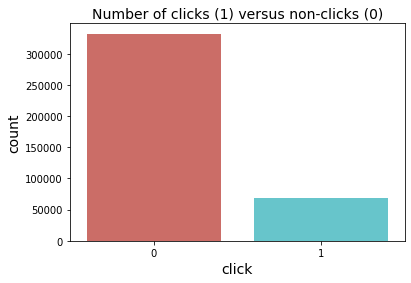

In [12]:
#plot count
plt.title('Number of clicks (1) versus non-clicks (0)',y=1,size=14) 
plt.ylabel('Count', size=14)
plt.xlabel('Clicks versus non-clicks', size=14)
sns.countplot(x='click',data=df, palette='hls')

In [13]:
#find percentage of clicks/non-clicks
print('Clicks makes up ', round(df['click'].value_counts()[0]/len(df) * 100,2), '% of the data')
print('Non-clicks makes up', round(df['click'].value_counts()[1]/len(df) * 100,2), '% of the data')

Clicks makes up  83.02 % of the data
Non-clicks makes up 16.98 % of the data


## Feature: Device Type

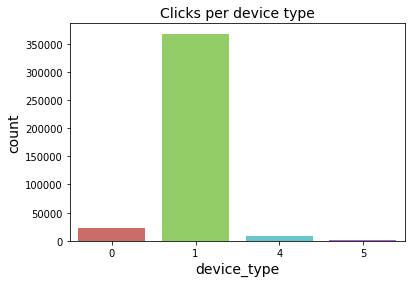

In [14]:
#check distribution of clicks across device types
plt.title('Clicks per device type',y=1,size=14) 
plt.ylabel('Count', size=14)
plt.xlabel('Device type', size=14)
sns.countplot(x='device_type', data = df, palette='hls')

In [15]:
df.loc[:,'device_type'].value_counts()

1    368719
0     22289
4      7696
5      1296
Name: device_type, dtype: int64

In [16]:
#get and plot clicks vs non-clicks per device type
device_type_count = pd.crosstab(index=df.device_type, columns=df.click)
device_type_count

click,0,1
device_type,,
0,17536,4753
1,306423,62296
4,6948,748
5,1171,125


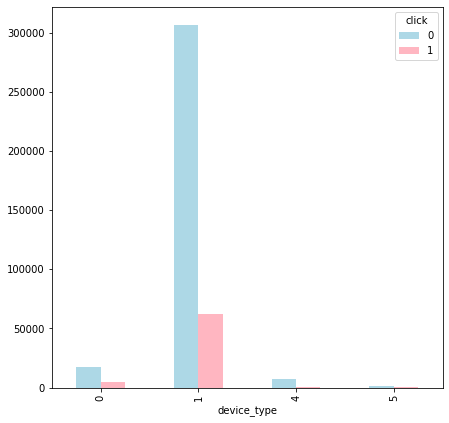

In [17]:
device_type_count.plot(kind='bar', figsize= (7,7), stacked=False, color=["lightblue","lightpink"])

## Feature: Cite Category

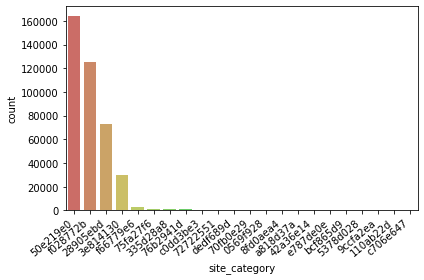

In [19]:
#check distribution of clicks across cite categories
ax = sns.countplot(x='site_category', data=df, palette='hls', order = df['site_category'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [20]:
#get and plot clicks vs non-clicks per cite category
site_category_count = pd.crosstab(index=df.site_category, columns=df.click)

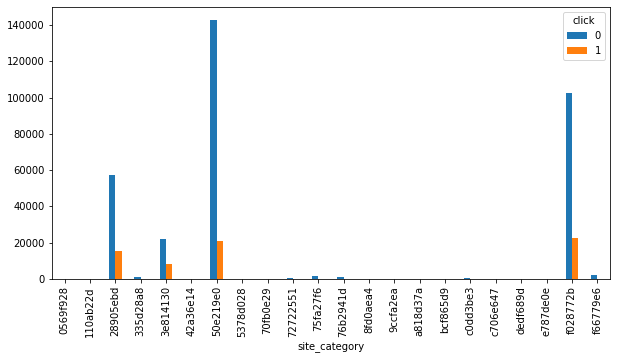

In [21]:
site_category_count.plot(kind='bar', figsize= (10,5), stacked=False)

## Feature: App Category

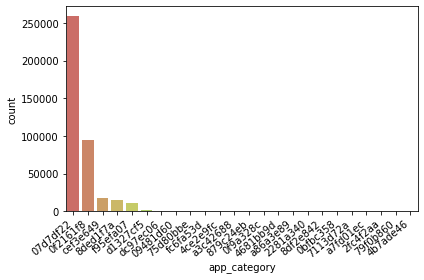

In [22]:
#check distribution of clicks across app category (plot in descending order)
ax = sns.countplot(x='app_category', data=df, palette='hls', order = df['app_category'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [23]:
#get and plot clicks vs non-clicks per app category
app_category_count = pd.crosstab(index=df.app_category, columns=df.click)

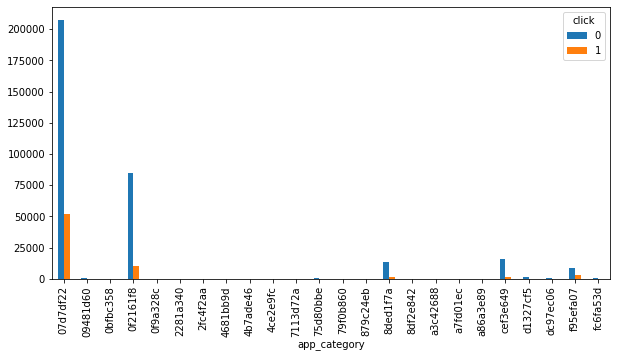

In [24]:
app_category_count.plot(kind='bar', figsize= (10,5), stacked=False)

## Feature: Banner position

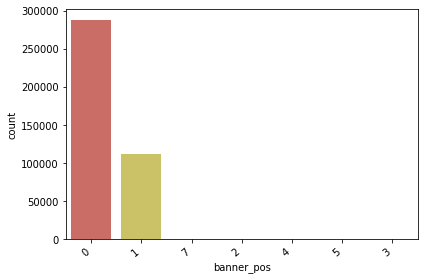

In [25]:
#check distribution of clicks depending on banner position
ax = sns.countplot(x='banner_pos', data=df, palette='hls', order = df['banner_pos'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [26]:
#get and plot clicks vs non-clicks per banner position
banner_pos_count = pd.crosstab(index=df.banner_pos, columns=df.click)

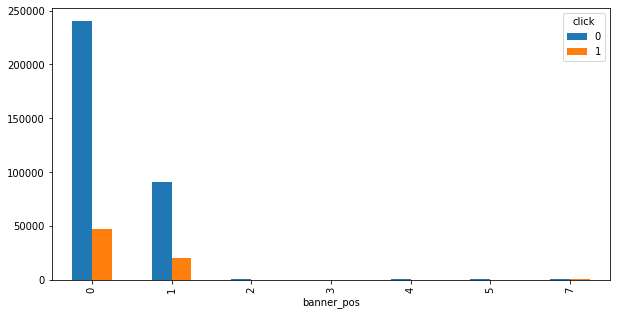

In [27]:
banner_pos_count.plot(kind='bar', figsize= (10,5), stacked=False)

Text(0, 0.5, 'Click through rate')

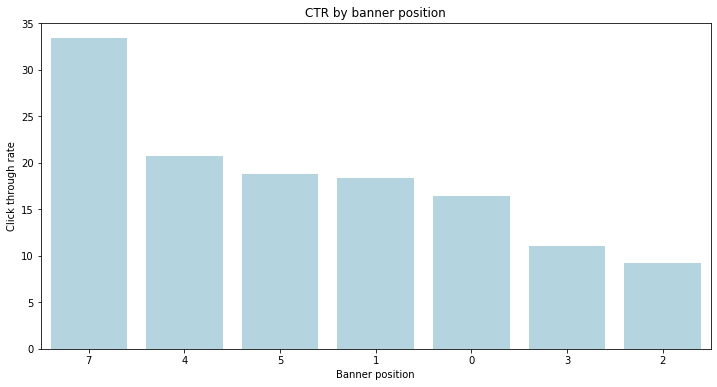

In [26]:
#plot CTR for banner position
df_click = df[df['click'] == 1]
df_banner = df[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners, color = 'lightblue')
plt.title('CTR by banner position')
plt.xlabel('Banner position')
plt.ylabel('Click through rate')

## Correlations

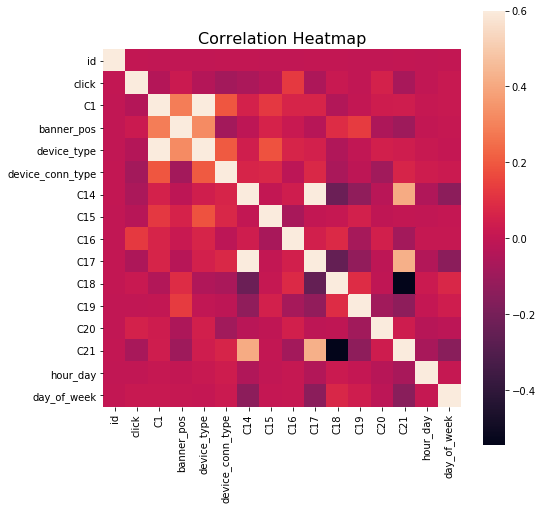

In [28]:
#plot correlation between target variable and features
correlation = df.corr()
f , ax = plt.subplots(figsize = (8,8)) 
plt.title('Correlation Heatmap',y=1,size=16) 
sns.heatmap(correlation, square = True, vmax=0.6)

In [31]:
#want to find the features which have the strongest correlation with clicks
correlation = df.corr()['click'][:] 

#make a list of the features which have a correlation with absolute value larger than 0.05 to list out
features_list = correlation[abs(correlation) > 0].sort_values(ascending=False)
print("Sorted list of values which are notably correlated with Clicks:\n{}".format(features_list))

Sorted list of values which are notably correlated with Clicks:
click               1.000000
C16                 0.127568
C20                 0.056096
banner_pos          0.026581
C18                 0.020243
day_of_week         0.015957
id                  0.000864
hour_day           -0.002237
C19                -0.002522
C15                -0.031450
C1                 -0.036841
device_type        -0.038030
C17                -0.054970
C14                -0.059030
C21                -0.069117
device_conn_type   -0.082344
Name: click, dtype: float64


## Feature: Time related features - time of day / day of week

Text(0.5, 1.0, 'Clicks over time')

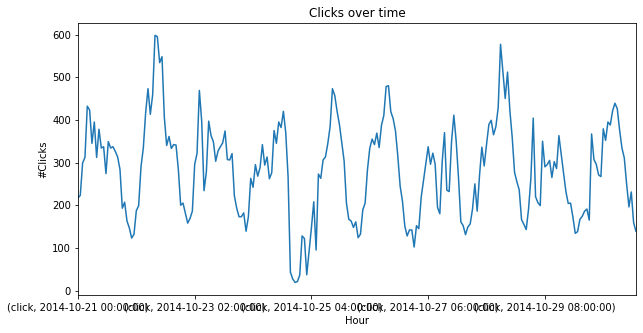

In [34]:
#plot number of clicks across the time period in the dataset
df_click = df[df.click==1]
temp_click = df_click.groupby('hour').agg({'click' : 'sum'})
temp_click.unstack().plot(figsize=(10,5))
plt.ylabel('#Clicks')
plt.xlabel('Hour')
plt.title('Clicks over time')

Text(0, 0.5, 'Count')

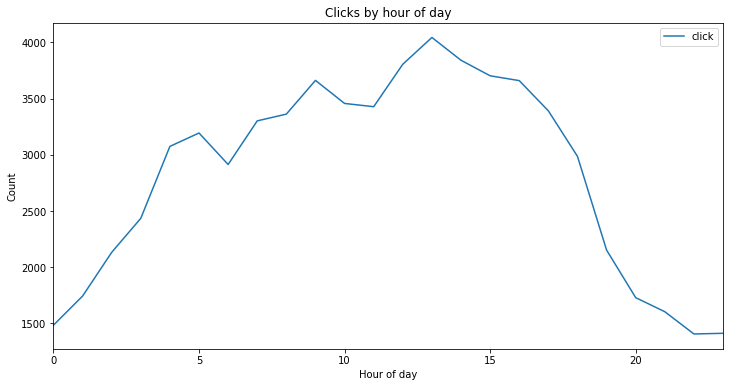

In [35]:
#plot number of clicks per hour of day
df.groupby('hour_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.title('Clicks by hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Count')

Text(0.5, 1.0, 'Clicks and non-clicks per hour')

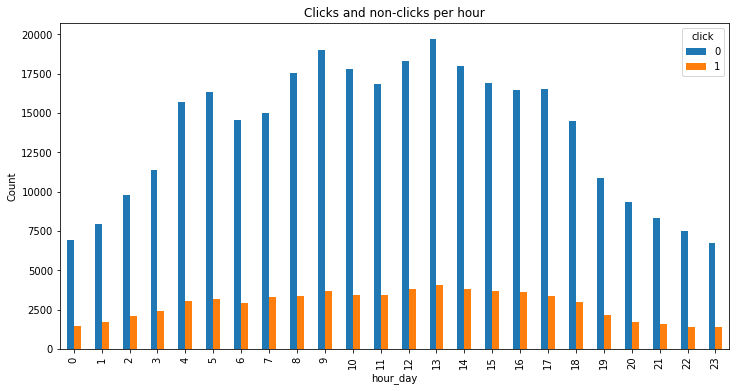

In [36]:
# clicks versus non-clicks per hour
df.groupby(['hour_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('Count')
plt.title('Clicks and non-clicks per hour')

Text(0.5, 1.0, 'CTR per hour')

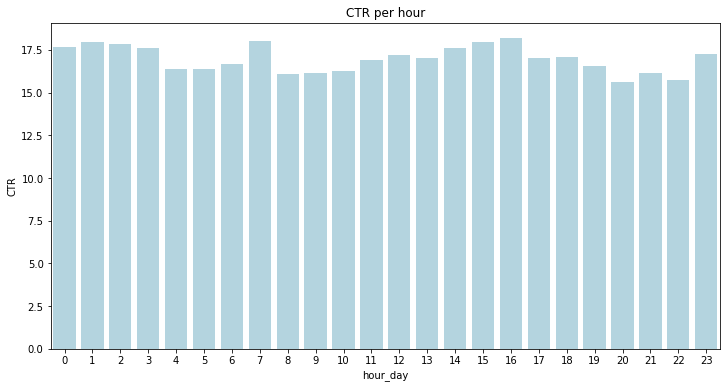

In [37]:
# get click through rate per hour

#create new dataframe which has CTR as one column
df_hour = df[['hour_day','click']].groupby(['hour_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_day','click']].groupby(['hour_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100

#plot
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_day', data=df_hour, color = 'lightblue')
plt.title('CTR per hour')

Text(0.5, 1.0, 'Clicks by day of week')

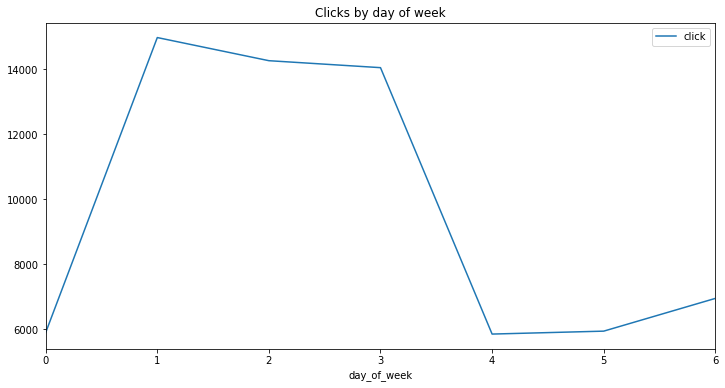

In [38]:
#plot number of clicks depending on day of week
df.groupby('day_of_week').agg({'click':'sum'}).plot(figsize=(12,6))
plt.title('Clicks by day of week')

Text(0.5, 1.0, 'Day of week CTR')

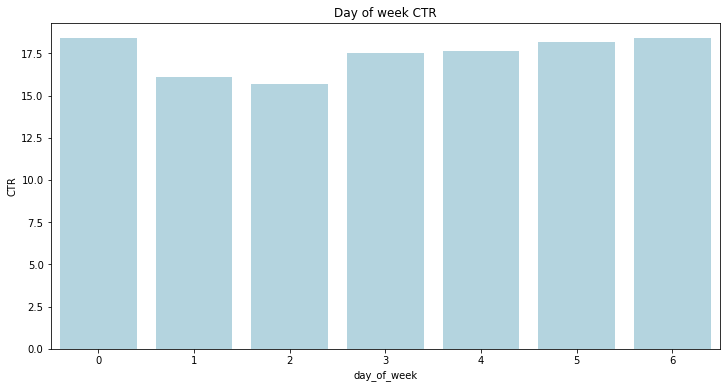

In [39]:
#get CTR per weekday

#create own dataframe CTR as column
df_dayofweek = df[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100

#plot
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, color = 'lightblue')
plt.title('Day of week CTR')

# Drop columns

In [8]:
df.nunique()

id                   65385
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               2155
site_domain           2154
site_category           22
app_id                2285
app_domain             141
app_category            24
device_id            64718
device_ip           260683
device_model          4390
device_type              4
device_conn_type         4
C14                   2083
C15                      8
C16                      9
C17                    418
C18                      4
C19                     66
C20                    160
C21                     60
hour_day                24
day_of_week              7
dtype: int64

In [9]:
df.drop(['id','hour', 'C19', 'C18', 'C14', 'site_id', 'site_domain','app_id', 'device_id', 
        "device_ip", "device_model"], axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 15 columns):
click               400000 non-null uint16
C1                  400000 non-null uint16
banner_pos          400000 non-null uint16
site_category       400000 non-null object
app_domain          400000 non-null object
app_category        400000 non-null object
device_type         400000 non-null uint16
device_conn_type    400000 non-null uint16
C15                 400000 non-null uint16
C16                 400000 non-null uint16
C17                 400000 non-null uint16
C20                 400000 non-null uint16
C21                 400000 non-null uint16
hour_day            400000 non-null uint16
day_of_week         400000 non-null uint16
dtypes: object(3), uint16(12)
memory usage: 18.3+ MB


In [11]:
df.head(3)

,click,C1,banner_pos,site_category,app_domain,app_category,device_type,device_conn_type,C15,C16,C17,C20,C21,hour_day,day_of_week
0,0,1005,1,3e814130,7801e8d9,07d7df22,1,0,320,50,1800,34541,23,4,3
1,1,1005,0,f028772b,7801e8d9,07d7df22,1,0,320,50,2547,65535,13,4,3
2,0,1005,0,28905ebd,7801e8d9,07d7df22,1,0,320,50,2545,34548,221,4,3


## Preprocessing: Dummy Encoding

In [12]:
#specify categorical columns to be encoded
cat_columns = ["site_category", "app_category", "app_domain"]

In [13]:
#create dummy variables
df_preprocessed = pd.get_dummies(df, columns = cat_columns, prefix = 'int_').astype(np.int8)

In [14]:
#look at data
df_preprocessed.head(2)

,click,C1,banner_pos,device_type,device_conn_type,C15,C16,C17,C20,C21,...,int__f435cae0,int__f75ccedd,int__f7f22564,int__f84a2400,int__fc41b20c,int__fd0f197b,int__fd5f0ee2,int__fd68cbd8,int__fdbdd2a9,int__fe369646
0,0,-19,1,1,0,64,50,8,-19,23,...,0,0,0,0,0,0,0,0,0,0
1,1,-19,0,1,0,64,50,-13,-1,13,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_preprocessed.shape

(400000, 199)

# Create train and test sets

In [16]:
#separate out features and target variable
X = df_preprocessed.drop('click', axis=1)
#X = df_preprocessed.drop('click', axis=1).iloc[:,[ XX]] #use in case of selected variables 
y = df_preprocessed.click

In [17]:
X.head()

,C1,banner_pos,device_type,device_conn_type,C15,C16,C17,C20,C21,hour_day,...,int__f435cae0,int__f75ccedd,int__f7f22564,int__f84a2400,int__fc41b20c,int__fd0f197b,int__fd5f0ee2,int__fd68cbd8,int__fdbdd2a9,int__fe369646
0,-19,1,1,0,64,50,8,-19,23,4,...,0,0,0,0,0,0,0,0,0,0
1,-19,0,1,0,64,50,-13,-1,13,4,...,0,0,0,0,0,0,0,0,0,0
2,-19,0,1,0,64,50,-15,-12,-35,4,...,0,0,0,0,0,0,0,0,0,0
3,-19,0,1,0,64,50,-12,-1,-100,4,...,0,0,0,0,0,0,0,0,0,0
4,-19,1,1,0,64,50,-32,-15,-35,4,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#create train and test sets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, 
                                        test_size= 0.2, random_state = 5, stratify = y)

## Scale: MinMax

In [34]:
#standardize (NOT if descision tree or XGBoost)
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Feature Selection with Recursive Feature Elimination

In [40]:
logreg = LogisticRegression(solver ='liblinear')
rfe = RFE(logreg)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

KeyboardInterrupt: 

# Model 1: Decision Tree

In [31]:
#find best three max depth and minimum samples for split with grid search
params = {'max_depth' : [5,10,15,20,None],
          'min_samples_split' : range(10,500,50)
        }

decision_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree, params, cv=5,scoring='roc_auc') #setting cv = 5 ensures stratified split
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_split': 210}


In [19]:
#stratified k-fold with 5 splits
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
pred_test_full = 0
scores_auc =[]
scores_logloss =[]
i=1
for train_index,test_index in kf.split(X_train,y_train):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    descision_tree_model = DecisionTreeClassifier(max_depth=10, min_samples_split= 210)
    descision_tree_model.fit(xtr,ytr)
    
    #get roc_auc
    auc = roc_auc_score(yvl,descision_tree_model.predict(xvl))
    print('ROC AUC score:',auc)
    scores_auc.append(auc) 
    
    #get logloss
    logloss = log_loss(yvl,descision_tree_model.predict(xvl))
    print('Logloss score:',logloss)
    scores_logloss.append(logloss)
    
    pred_test = descision_tree_model.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1
    
print(np.mean(scores_auc))
print(np.mean(scores_logloss))

1 of KFold 5
ROC AUC score: 0.5236925130445335
Logloss score: 5.833189773270449
2 of KFold 5
ROC AUC score: 0.5248977474127753
Logloss score: 5.832650663036109
3 of KFold 5
ROC AUC score: 0.5269115893637379
Logloss score: 5.834361090701556
4 of KFold 5
ROC AUC score: 0.5236093859819615
Logloss score: 5.785342388625037
5 of KFold 5
ROC AUC score: 0.522903050111081
Logloss score: 5.85927682521885
0.5244028571828178
5.8289641481704


In [20]:
#test different k-fold function (cv=10 makes stratified)
descision_tree_model = DecisionTreeClassifier(max_depth=10,min_samples_split= 210) 
print(cross_val_score(descision_tree_model, X_train, y_train, cv=10, scoring='neg_log_loss').mean())

-0.42478500286810494


In [21]:
#different scoring
print(cross_val_score(descision_tree_model, X_train, y_train, cv=10, scoring='roc_auc').mean())

0.6942606406661594


In [22]:
#fit model
descision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=210,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [23]:
#investigate feature importance
print(np.where(descision_tree_model.feature_importances_ > 0.001))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  13,  14,
        15,  31,  33,  52,  55,  87, 106, 113, 134, 142, 153, 154]),)


In [24]:
#Look at model results on test set
y_predict_DT = descision_tree_model.predict(X_test)

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict_DT)
print(confusion_matrix)

[[65881   535]
 [12842   742]]


In [26]:
print(classification_report(y_test, y_predict_DT))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     66416
           1       0.58      0.05      0.10     13584

    accuracy                           0.83     80000
   macro avg       0.71      0.52      0.50     80000
weighted avg       0.79      0.83      0.77     80000



In [27]:
print('ROC AUC: %f' % roc_auc_score(y_test, y_predict_DT))

ROC AUC: 0.523284


## Model 2: Logistic Regression

In [114]:
#find best hyperparameter value with grid search
params ={'penalty' : ['l1', 'l2']
        }

logreg = LogisticRegression(solver ='lbfgs')
grid_search = GridSearchCV(logreg, params, cv=5)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

{'penalty': 'l2'}


In [35]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
pred_test_full = 0
scores_auc =[]
scores_logloss =[]
i=1
for train_index,test_index in kf.split(X_train,y_train):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    logreg = LogisticRegression(solver ='liblinear', penalty ='l2')
    logreg.fit(xtr,ytr)
    
    #get roc_auc
    auc = roc_auc_score(yvl,logreg.predict(xvl))
    print('ROC AUC score:',auc)
    scores_auc.append(auc) 
    
    #get logloss
    logloss = log_loss(yvl,logreg.predict(xvl))
    print('Logloss score:',logloss)
    scores_logloss.append(logloss)
    
    pred_test = logreg.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1
    
print(np.mean(scores_auc))
print(np.mean(scores_logloss))

1 of KFold 5
ROC AUC score: 0.5019618181516164
Logloss score: 5.935180955989056
2 of KFold 5
ROC AUC score: 0.5017050747788009
Logloss score: 5.938419078098648
3 of KFold 5
ROC AUC score: 0.5020739891939585
Logloss score: 5.946067085802321
4 of KFold 5
ROC AUC score: 0.5005412589379895
Logloss score: 5.8344466067729375
5 of KFold 5
ROC AUC score: 0.5019068984697309
Logloss score: 5.939683735355833
0.5016378079064193
5.918759492403759


In [36]:
logreg = LogisticRegression(solver ='liblinear', penalty ='l2')
print(cross_val_score(logreg, X_train, y_train, cv=10, scoring='neg_log_loss').mean())

-0.43129911742725363


In [37]:
print(cross_val_score(logreg, X_train, y_train, cv=10, scoring='roc_auc').mean())

0.646894523288208


In [38]:
logreg = LogisticRegression(solver ='liblinear', penalty ='l2')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
y_predict_logistic = logreg.predict(X_test)

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict_logistic)
print(confusion_matrix)

[[66348    68]
 [13527    57]]


In [41]:
print(classification_report(y_test, y_predict_logistic))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     66416
           1       0.46      0.00      0.01     13584

    accuracy                           0.83     80000
   macro avg       0.64      0.50      0.46     80000
weighted avg       0.77      0.83      0.75     80000



# Model 3: XGBoost

In [28]:
#test following parameters
# max_depth':[3,5,7]
#'subsample':[0.4,0.6]

# create instance of model
XGB_model = XGBClassifier(max_depth=5, subsample=0.6)

In [29]:
XGB_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.649072
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.613377
[2]	validation_0-logloss:0.583598
[3]	validation_0-logloss:0.559091
[4]	validation_0-logloss:0.538811
[5]	validation_0-logloss:0.52151
[6]	validation_0-logloss:0.507307
[7]	validation_0-logloss:0.494706
[8]	validation_0-logloss:0.484652
[9]	validation_0-logloss:0.475777
[10]	validation_0-logloss:0.468604
[11]	validation_0-logloss:0.462357
[12]	validation_0-logloss:0.457056
[13]	validation_0-logloss:0.45268
[14]	validation_0-logloss:0.448784
[15]	validation_0-logloss:0.44545
[16]	validation_0-logloss:0.44251
[17]	validation_0-logloss:0.440197
[18]	validation_0-logloss:0.438144
[19]	validation_0-logloss:0.436508
[20]	validation_0-logloss:0.435076
[21]	validation_0-logloss:0.433933
[22]	validation_0-logloss:0.43253
[23]	validation_0-logloss:0.431672
[24]	validation_0-logloss:0.430521
[25]	validation_0-logloss:0.429589
[26]	validation_0-logloss:0.428935
[2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=0.6)

In [30]:
y_predict_XGB = XGB_model.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict_XGB)
print(confusion_matrix)

[[65880   536]
 [12819   765]]


In [32]:
print(classification_report(y_test, y_predict_XGB))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     66416
           1       0.59      0.06      0.10     13584

    accuracy                           0.83     80000
   macro avg       0.71      0.52      0.51     80000
weighted avg       0.79      0.83      0.77     80000



In [33]:
#AUC
auc = roc_auc_score(y_test, y_predict_XGB)
print('ROC AUC: %f' % auc)

ROC AUC: 0.524123


# Multilayer Perceptron

In [52]:
# number of times the entire training dataset 
#is shown to the network during training
N_EPOCH = 20 

# number of training examples in one 
#backward/forward pass (before updating weights)
BATCH_SIZE = 128 

VERBOSE = 1
OPTIMIZER = SGD() # Stochastic Gradient Descent optimizer
N_HIDDEN = 128 # number of hidden units
VALIDATION_SPLIT= 0.2 # proportion of data used for validation
INPUT_SHAPE = X_train[1].size

# random seed 
np.random.seed(222) 

In [33]:
#create model object
model = Sequential()

# hidden layer 1 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN, input_shape=(INPUT_SHAPE,)))
model.add(Activation('relu'))

# hidden layer 2 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))

# output layer with 10 units (0-9) and softmax activation
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilation
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

In [34]:
#train the network
history = model.fit(X_train, 
                    y_train, batch_size=BATCH_SIZE, 
                    epochs=N_EPOCH, verbose=VERBOSE, 
                    validation_split=0.2)

Train on 256000 samples, validate on 64000 samples
Epoch 1/20
256000/256000 [==============================] - 8s 33us/step - loss: 0.4540 - acc: 0.8284 - val_loss: 0.4451 - val_acc: 0.8298
Epoch 2/20
256000/256000 [==============================] - 8s 32us/step - loss: 0.4424 - acc: 0.8303 - val_loss: 0.4419 - val_acc: 0.8298
Epoch 3/20
256000/256000 [==============================] - 8s 31us/step - loss: 0.4397 - acc: 0.8303 - val_loss: 0.4396 - val_acc: 0.8298
Epoch 4/20
256000/256000 [==============================] - 9s 34us/step - loss: 0.4377 - acc: 0.8303 - val_loss: 0.4377 - val_acc: 0.8298
Epoch 5/20
256000/256000 [==============================] - 8s 32us/step - loss: 0.4360 - acc: 0.8303 - val_loss: 0.4364 - val_acc: 0.8298
Epoch 6/20
256000/256000 [==============================] - 8s 32us/step - loss: 0.4346 - acc: 0.8303 - val_loss: 0.4349 - val_acc: 0.8298
Epoch 7/20
256000/256000 [==============================] - 8s 32us/step - loss: 0.4335 - acc: 0.8303 - val_loss: 0

In [35]:
#test the network
score = model.evaluate(X_test, y_test, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print("Test accuracy:", score[1])

80000/80000 [==============================] - 2s 30us/step

Test score/loss: 0.4295063109636307
Test accuracy: 0.83025


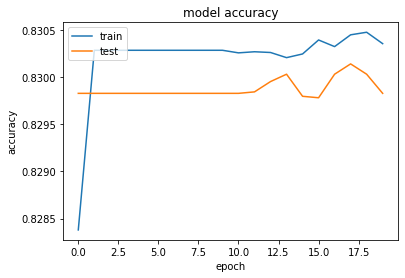

In [36]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

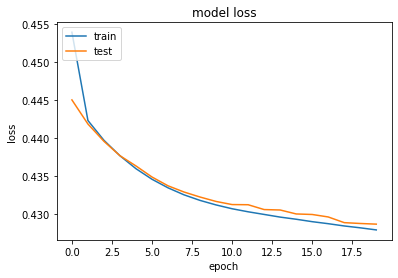

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Hyperparameter tuning

## Number of layers

In [56]:
N_LAYERS = [2,3] #in addition to first hidden layer and output layer
test_score = []
test_accuracy = []    
  
for i in N_LAYERS:
    
    model = Sequential()
    
    # Hidden layer 1 which reshapes the input
    model.add(Dense(N_HIDDEN, input_shape=(INPUT_SHAPE,)))
    model.add(Activation('relu'))
    
    #loop to add i layers with ReLU activation function
    for j in range(i):
            model.add(Dense(N_HIDDEN))
            model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # compilation
    model.compile(loss='binary_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, 
                        batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                        verbose=VERBOSE, 
                        validation_split=0.2)

    score = model.evaluate(X_test, y_test, 
                           verbose=VERBOSE)
    test_score.append(score[0])
    test_accuracy.append(score[1])

Train on 256000 samples, validate on 64000 samples
Epoch 1/20
256000/256000 [==============================] - 10s 40us/step - loss: 0.4538 - acc: 0.8282 - val_loss: 0.4453 - val_acc: 0.8298
Epoch 2/20
256000/256000 [==============================] - 12s 45us/step - loss: 0.4426 - acc: 0.8303 - val_loss: 0.4417 - val_acc: 0.8298
Epoch 3/20
256000/256000 [==============================] - 15s 59us/step - loss: 0.4397 - acc: 0.8303 - val_loss: 0.4390 - val_acc: 0.8298
Epoch 4/20
256000/256000 [==============================] - 12s 46us/step - loss: 0.4371 - acc: 0.8303 - val_loss: 0.4364 - val_acc: 0.8298
Epoch 5/20
256000/256000 [==============================] - 13s 49us/step - loss: 0.4348 - acc: 0.8303 - val_loss: 0.4342 - val_acc: 0.8298
Epoch 6/20
256000/256000 [==============================] - 13s 52us/step - loss: 0.4328 - acc: 0.8303 - val_loss: 0.4328 - val_acc: 0.8298
Epoch 7/20
256000/256000 [==============================] - 12s 49us/step - loss: 0.4313 - acc: 0.8303 - val_

In [57]:
for i in range(len(N_LAYERS)):
    print("\nUsing " + str(N_LAYERS[i]+1) + " hidden layers gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using 3 hidden layers gave:
Test score/loss 0.42619715408682823
Test accuracy: 0.8310125

Using 4 hidden layers gave:
Test score/loss 0.4251708738267422
Test accuracy: 0.830975


## Hyperparameter tuning: Dropout

In [58]:
#create vector to hold the dropout percentages we want to try
P_DROPOUT = [0.1, 0.2, 0.3, 0.4, 0.5]
test_score = []
test_accuracy = []

for i in P_DROPOUT:
    model = Sequential()

    # Hidden layer 1 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN, input_shape=(INPUT_SHAPE,)))
    model.add(Activation('relu'))
    model.add(Dropout(i))

    # Hidden layer 2 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    model.add(Dropout(i))
    
    # Hidden layer 3 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    model.add(Dropout(i))
    
    # Hidden layer 4 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    model.add(Dropout(i))

    # output layer with 10 units and softmax activation
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # compilation
    model.compile(loss='binary_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])
    
    #train the network
    history = model.fit(X_train, y_train, 
                        batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                        verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

    score = model.evaluate(X_test, 
                           y_test, verbose=VERBOSE)
    
    test_score.append(score[0])
    test_accuracy.append(score[1])

Train on 256000 samples, validate on 64000 samples
Epoch 1/20
256000/256000 [==============================] - 11s 43us/step - loss: 0.4559 - acc: 0.8281 - val_loss: 0.4460 - val_acc: 0.8298
Epoch 2/20
256000/256000 [==============================] - 10s 40us/step - loss: 0.4451 - acc: 0.8303 - val_loss: 0.4428 - val_acc: 0.8298
Epoch 3/20
256000/256000 [==============================] - 11s 41us/step - loss: 0.4425 - acc: 0.8303 - val_loss: 0.4408 - val_acc: 0.8298
Epoch 4/20
256000/256000 [==============================] - 11s 43us/step - loss: 0.4406 - acc: 0.8303 - val_loss: 0.4389 - val_acc: 0.8298
Epoch 5/20
256000/256000 [==============================] - 10s 40us/step - loss: 0.4390 - acc: 0.8303 - val_loss: 0.4372 - val_acc: 0.8298
Epoch 6/20
256000/256000 [==============================] - 10s 39us/step - loss: 0.4373 - acc: 0.8303 - val_loss: 0.4357 - val_acc: 0.8298
Epoch 7/20
256000/256000 [==============================] - 10s 41us/step - loss: 0.4361 - acc: 0.8303 - val_

In [59]:
for i in range(len(P_DROPOUT)):
    print("\nUsing dropout rate " + str(P_DROPOUT[i]) + " gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using dropout rate 0.1 gave:
Test score/loss 0.4291415367603302
Test accuracy: 0.8302

Using dropout rate 0.2 gave:
Test score/loss 0.4295531588256359
Test accuracy: 0.8302

Using dropout rate 0.3 gave:
Test score/loss 0.4295654796898365
Test accuracy: 0.8302

Using dropout rate 0.4 gave:
Test score/loss 0.43023219926953316
Test accuracy: 0.8302

Using dropout rate 0.5 gave:
Test score/loss 0.43101088473796845
Test accuracy: 0.8302


## Hyperparameter tuning: Learning rate

In [60]:
#specify vector of learning rates we will test
LEARN_R = [0.1,0.2, 0.3, 0.5]
test_score = []
test_accuracy = []

for i in LEARN_R:
    model = Sequential()

    # Hidden layer 1 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN, input_shape=(INPUT_SHAPE,)))
    model.add(Activation('relu'))
    # Hidden layer 2 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    # Hidden layer 3 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    # Hidden layer 4 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    #for each loop we want to use a new value for the learning rate
    OPTIMIZER = SGD(lr = i)    

    # compilation
    model.compile(loss='binary_crossentropy', 
                  optimizer=OPTIMIZER, metrics=['accuracy'])
    
    #train the network
    history = model.fit(X_train, y_train, 
                        batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                        verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

    #get the score and store them to print after finish
    score = model.evaluate(X_test, y_test, verbose=VERBOSE)
    test_score.append(score[0])
    test_accuracy.append(score[1])

Train on 256000 samples, validate on 64000 samples
Epoch 1/20
256000/256000 [==============================] - 11s 43us/step - loss: 0.4388 - acc: 0.8303 - val_loss: 0.4323 - val_acc: 0.8298
Epoch 2/20
256000/256000 [==============================] - 8s 33us/step - loss: 0.4310 - acc: 0.8303 - val_loss: 0.4324 - val_acc: 0.8299
Epoch 3/20
256000/256000 [==============================] - 8s 32us/step - loss: 0.4289 - acc: 0.8306 - val_loss: 0.4313 - val_acc: 0.8289
Epoch 4/20
256000/256000 [==============================] - 9s 35us/step - loss: 0.4274 - acc: 0.8309 - val_loss: 0.4265 - val_acc: 0.8301
Epoch 5/20
256000/256000 [==============================] - 9s 34us/step - loss: 0.4264 - acc: 0.8310 - val_loss: 0.4273 - val_acc: 0.8303
Epoch 6/20
256000/256000 [==============================] - 9s 37us/step - loss: 0.4255 - acc: 0.8311 - val_loss: 0.4284 - val_acc: 0.8303
Epoch 7/20
256000/256000 [==============================] - 11s 42us/step - loss: 0.4249 - acc: 0.8312 - val_loss:

In [61]:
for i in range(len(LEARN_R)):
    print("\nUsing learning rate " + str(LEARN_R[i]) + " gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using learning rate 0.1 gave:
Test score/loss 0.4227749087691307
Test accuracy: 0.832125

Using learning rate 0.2 gave:
Test score/loss 0.42122393339276315
Test accuracy: 0.831875

Using learning rate 0.3 gave:
Test score/loss 0.41971718744635583
Test accuracy: 0.8317625

Using learning rate 0.5 gave:
Test score/loss 0.41991469141840937
Test accuracy: 0.8324


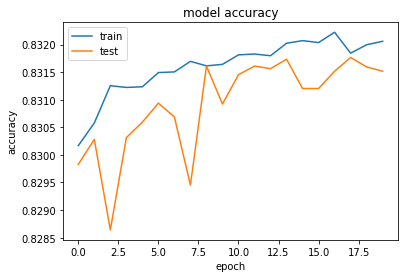

In [62]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

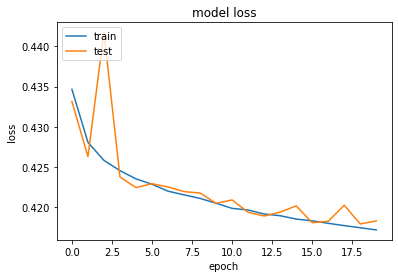

In [63]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Hyperparameter tuning: Optimizer

In [65]:
#define vector with optimization algorithms to try
OPTIMIZER = ["Adagrad", "Adam", "RMSprop"]
test_score = []
test_accuracy = []

for i in OPTIMIZER:
    model = Sequential()

    # Hidden layer 1 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN, input_shape=(INPUT_SHAPE,)))
    model.add(Activation('relu'))
    # Hidden layer 2 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    # Hidden layer 3 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    # Hidden layer 4 with 128 hidden units and ReLu activation function
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))

    # output layer with 10 units and softmax activation
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # compilation with optimization algorithm i
    model.compile(loss='binary_crossentropy', optimizer=i, metrics=['accuracy'])
    
    #train the network
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                        epochs=N_EPOCH, verbose=VERBOSE, validation_split=0.2)

    #get the score and store them to print after finish
    score = model.evaluate(X_test, y_test, verbose=VERBOSE)
    test_score.append(score[0])
    test_accuracy.append(score[1])

Train on 256000 samples, validate on 64000 samples
Epoch 1/20
256000/256000 [==============================] - 12s 45us/step - loss: 0.4292 - acc: 0.8302 - val_loss: 0.4260 - val_acc: 0.8300
Epoch 2/20
256000/256000 [==============================] - 11s 44us/step - loss: 0.4245 - acc: 0.8306 - val_loss: 0.4237 - val_acc: 0.8298
Epoch 3/20
256000/256000 [==============================] - 10s 41us/step - loss: 0.4230 - acc: 0.8312 - val_loss: 0.4223 - val_acc: 0.8304
Epoch 4/20
256000/256000 [==============================] - 10s 37us/step - loss: 0.4221 - acc: 0.8316 - val_loss: 0.4218 - val_acc: 0.8306
Epoch 5/20
256000/256000 [==============================] - 10s 37us/step - loss: 0.4213 - acc: 0.8316 - val_loss: 0.4212 - val_acc: 0.8308
Epoch 6/20
256000/256000 [==============================] - 10s 38us/step - loss: 0.4208 - acc: 0.8319 - val_loss: 0.4208 - val_acc: 0.8308
Epoch 7/20
256000/256000 [==============================] - 11s 41us/step - loss: 0.4203 - acc: 0.8318 - val_

In [66]:
for i in range(len(OPTIMIZER)):
    print("\nUsing Optimizer " + str(OPTIMIZER[i]) + " gave:")
    print("Test score/loss", test_score[i])
    print("Test accuracy:", test_accuracy[i])


Using Optimizer Adagrad gave:
Test score/loss 0.4210247407913208
Test accuracy: 0.83245

Using Optimizer Adam gave:
Test score/loss 0.4200598096847534
Test accuracy: 0.832375

Using Optimizer RMSprop gave:
Test score/loss 0.4241208064317703
Test accuracy: 0.832525


## Multilayer Perceptron with Focal Loss

In [118]:
N_EPOCH = 20
BATCH_SIZE = 128 
VERBOSE = 1
OPTIMIZER = Adam(lr=0.01)
N_HIDDEN = 128 
VALIDATION_SPLIT= 0.2 
INPUT_SHAPE = X_train[1].size 
np.random.seed(222)

In [119]:
_EPSILON = K.epsilon()

def focal_loss(y_true, y_pred):
   y_pred_hat = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
   y_pred_hat = K.clip(y_pred_hat, _EPSILON, 1-_EPSILON)
   return(K.mean(K.pow(1-y_pred_hat, 2) * keras.losses.binary_crossentropy(y_true, y_pred), axis=-1))

In [120]:
#create model object
model = Sequential()

# hidden layer 1 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN, input_shape=(INPUT_SHAPE,)))
model.add(Activation('relu'))

# hidden layer 2 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))

# hidden layer 3 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))

# hidden layer 4 with 128 hidden units and ReLu activation function
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))

# output layer with 10 units (0-9) and softmax activation
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilation
model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=OPTIMIZER)

In [121]:
#train the network
history = model.fit(X_train, 
                    y_train, batch_size=BATCH_SIZE, 
                    epochs=N_EPOCH, verbose=VERBOSE, 
                    validation_split=VALIDATION_SPLIT)

Train on 256000 samples, validate on 64000 samples
Epoch 1/20
256000/256000 [==============================] - 14s 56us/step - loss: 0.0599 - acc: 0.8297 - val_loss: 0.0653 - val_acc: 0.8283
Epoch 2/20
256000/256000 [==============================] - 14s 55us/step - loss: 0.0588 - acc: 0.8303 - val_loss: 0.0583 - val_acc: 0.8300
Epoch 3/20
256000/256000 [==============================] - 15s 58us/step - loss: 0.0584 - acc: 0.8311 - val_loss: 0.0587 - val_acc: 0.8307
Epoch 4/20
256000/256000 [==============================] - 16s 62us/step - loss: 0.0582 - acc: 0.8311 - val_loss: 0.0581 - val_acc: 0.8308
Epoch 5/20
256000/256000 [==============================] - 12s 48us/step - loss: 0.0580 - acc: 0.8314 - val_loss: 0.0591 - val_acc: 0.8305
Epoch 6/20
256000/256000 [==============================] - 16s 62us/step - loss: 0.0581 - acc: 0.8313 - val_loss: 0.0578 - val_acc: 0.8309
Epoch 7/20
256000/256000 [==============================] - 14s 56us/step - loss: 0.0578 - acc: 0.8313 - val_

In [122]:
#test the network
score = model.evaluate(X_test, y_test, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print("Test accuracy:", score[1])

80000/80000 [==============================] - 3s 43us/step

Test score/loss: 0.0620895591202192
Test accuracy: 0.832575


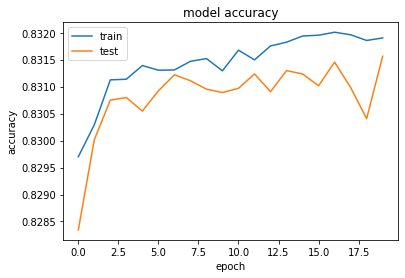

In [123]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

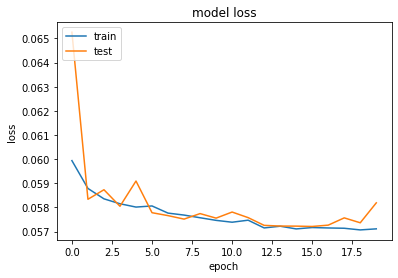

In [124]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Calculating Metrics for comparison

In [125]:
y_probs = model.predict_classes(X_test)
yhat_classes = y_probs[:,0]

In [126]:
#AUC
auc = roc_auc_score(y_test, yhat_classes)
print('ROC AUC: %f' % auc)

ROC AUC: 0.525703


In [127]:
print(classification_report(y_test, yhat_classes))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     66416
           1       0.56      0.06      0.11     13584

    accuracy                           0.83     80000
   macro avg       0.70      0.53      0.51     80000
weighted avg       0.79      0.83      0.77     80000

